In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#variáveis de interesse do dataframe original
variaveis_de_interesse = ['id', 'issue_d', 'earliest_cr_line', 'purpose', 'int_rate', 'installment', 'fico_range_low', 'fico_range_high', 'delinq_2yrs', 'pub_rec', 'last_pymnt_d', 'loan_status', 'funded_amnt','annual_inc', 'term']

#lendo o dataframe
df = pd.read_feather("lending_club_clean.feather")
df_small = df[variaveis_de_interesse]

#apenas contratos em dia, quitados ou que entramram em default ou charge off (default com perda)
df_small = df_small[df_small['loan_status'].isin(['Fully Paid','Current', 'Charged Off', 'Default'])]

#renomenado as colunas
df_small = df_small.rename(columns={'issue_d': 'data_celebracao', 
                                    'earliest_cr_line': 'data_primeiro_emprestimo', 
                                    'purpose': 'finalidade_emprestimo', 
                                    'int_rate': 'taxa_juros', 
                                    'installment': 'valor_parcela',   
                                    'delinq_2yrs': 'inadimplencia_2_anos', 
                                    'pub_rec': 'registros_publicos_negativos', 
                                    'last_pymnt_d': 'data_ultimo_pagamento', 
                                    'loan_status': 'status_emprestimo', 
                                    'funded_amnt': 'valor_financiado',
                                    'annual_inc': 'renda_anual',
                                    'term':'parcelas'})
#filtrando os dados
df_small = df_small.dropna()
df_small = df_small[df_small['valor_financiado'] > 0]
df_small = df_small[df_small['renda_anual'] > 0]
df_small = df_small[df_small['valor_parcela'] > 0]
df_small = df_small[df_small['taxa_juros'] > 0]
df_small = df_small[df_small['parcelas'] > 0]
df_small = df_small[df_small['finalidade_emprestimo'].isin(['debt_consolidation', 'credit_card', 'other', 'home_improvement', 'small_business', 'major_purchase', 'educational', 'wedding', 'car', 'medical', 'moving', 'vacation', 'house'])]    

# dicionário de mapeamento
map_finalidade = {
    'debt_consolidation': 'pagamento de dividas',
    'credit_card': 'cartao de credito',
    'other': 'outros',
    'home_improvement': 'reforma residencial',
    'small_business': 'pequeno negocio',
    'major_purchase': 'compra grande valor',
    'educational': 'financiamento estudantil',
    'wedding': 'festa de casamento',
    'car': 'compra de veiculo',
    'medical': 'despesas medicas',
    'moving': 'mudanca',
    'vacation': 'viagem',
    'house': 'compra de imovel'
}

# aplicando o mapeamento
df_small['finalidade_emprestimo'] = df_small['finalidade_emprestimo'].map(map_finalidade)

In [3]:
# Garantindo que as colunas são datetime
df_small['data_celebracao'] = pd.to_datetime(df_small['data_celebracao'])
df_small['data_primeiro_emprestimo'] = pd.to_datetime(df_small['data_primeiro_emprestimo'])

# Calculando o tempo de relacionamento em meses
df_small['tempo_relacionamento'] = (df_small['data_celebracao'].dt.year - df_small['data_primeiro_emprestimo'].dt.year) * 12 + (df_small['data_celebracao'].dt.month - df_small['data_primeiro_emprestimo'].dt.month)

#calculando o escore de crédito como a média entre o fico_range_low e fico_range_high
df_small['escore_fico'] = (df_small['fico_range_high'] + df_small['fico_range_low'])/2
df_small['escore_fico'] = df_small['escore_fico'].apply(lambda x: int(x))

#calculando a renda mensal, a relação parcela/renda e o tempo de relacionamento em meses
df_small['renda_mensal'] = df_small['renda_anual'] / 12

#calculando a relação parcela/renda
df_small['compm_renda'] = df_small['valor_parcela'] / df_small['renda_mensal']

#criando a variável de evento e tempo para análise de sobrevivência
df_small['default'] = df_small['status_emprestimo'].apply(lambda x: 1 if x in ['Charged Off', 'Default'] else 0)

#calculando o tempo de ocorrencia ou não ocorrencia do evento em meses
df_small['T'] = (df_small['data_ultimo_pagamento'].dt.year - df_small['data_celebracao'].dt.year) * 12 + (df_small['data_ultimo_pagamento'].dt.month - df_small['data_celebracao'].dt.month)
df_small['T'] = df_small['T'].apply(lambda x: int(x))

#transfirando as colunas de valor para float e arredondando para 2 casas decimais
df_small['valor_financiado'] = df_small['valor_financiado'].apply(lambda x: round(float(x),2))
df_small['valor_parcela'] = df_small['valor_parcela'].apply(lambda x: round(float(x),2))
df_small['renda_mensal'] = df_small['renda_mensal'].apply(lambda x: round(float(x),2))
#calculando a relação parcela/renda e arredondando para 4 casas decimais
df_small['compm_renda'] = df_small['compm_renda'].apply(lambda x: round(float(x),4))
df_small['taxa_juros'] = df_small['taxa_juros'].apply(lambda x: round(float(x),4))

#deletando as colunas que não serão mais utilizadas
df_small = df_small.drop(columns=['fico_range_low', 'fico_range_high', 'status_emprestimo'])

#outros filtros de dados
df_small = df_small[df_small['escore_fico'] > 0]
df_small = df_small[df_small['tempo_relacionamento'] >= 0]
df_small = df_small[df_small['compm_renda'] >= 0]

#ordenando as colunas
df_small = df_small[['id', 'data_celebracao', 'data_primeiro_emprestimo', 'data_ultimo_pagamento', 'valor_financiado', 'finalidade_emprestimo', 'parcelas', 'taxa_juros', 'valor_parcela', 'tempo_relacionamento', 'escore_fico', 'inadimplencia_2_anos', 'registros_publicos_negativos', 'renda_mensal', 'compm_renda','default','T']]


Parcelas mais comum: 36 (count: 2033575)


/var/folders/qf/kc1bvcc94rn94r3xhf1jbj1w0000gn/T/ipykernel_49127/300576527.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


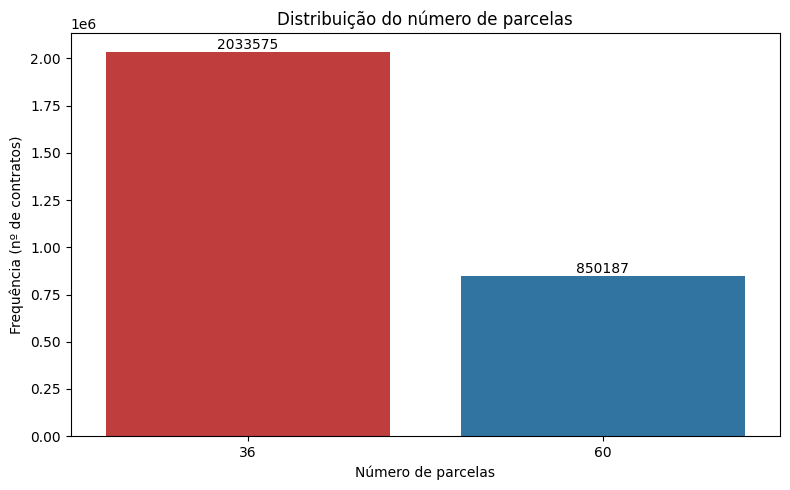

In [4]:
# contar ocorrência por número de parcelas e identificar a moda
counts = df_small['parcelas'].value_counts().sort_index()
mode_parcelas = df_small['parcelas'].mode().iloc[0]
print(f"Parcelas mais comum: {mode_parcelas} (count: {counts.get(mode_parcelas)})")

# plot da distribuição com destaque para a moda
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=counts.index,
    y=counts.values,
    palette=['C3' if p == mode_parcelas else 'C0' for p in counts.index]
)

plt.xlabel('Número de parcelas')
plt.ylabel('Frequência (nº de contratos)')
plt.title('Distribuição do número de parcelas')
plt.xticks(rotation=0)

# 🔢 valores no topo de cada barra
for i, v in enumerate(counts.values):
    ax.text(
        i,
        v,
        f'{v}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.savefig('figuras//qunatidade_de_contratos_parcela.png', dpi=600, bbox_inches='tight')
plt.show()


In [5]:
df_small = df_small[df_small['parcelas'] == 36].reset_index(drop=True)

In [6]:
df_small.to_csv("loan_data_total.csv", index=False, sep=';')

In [7]:
tamanho_gb = df_small.memory_usage(deep=True).sum() / (1024 ** 3)
print(f"Tamanho do dataframe df_small: {tamanho_gb:.2f} GB")

Tamanho do dataframe df_small: 0.26 GB


In [8]:
df_small.head(10000).to_csv("loan_data.csv", index=False, sep=';')